In [257]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.layers import Input, merge
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.constraints import maxnorm
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [258]:
path_train = '../../data/compstat3/train.csv'
path_test = '../../data/compstat3/test.csv'
path_submission = '../../data/compstat3/submission.csv'
random_state = 2018
epochs = 50
lrate = 0.01
batch_size = 128
img_width  = 32
img_height = 32
channels = 3

In [259]:
def load_train():
    data = pd.read_csv(
        path_train, delimiter=',',
        dtype='|U', encoding='utf-8'
    ).values
    x = data[:, :-1].astype(dtype=float)
    y = data[:, -1].astype(dtype=float)
    return (x, y)

In [260]:
def load_pred():
    data = pd.read_csv(
        path_test, delimiter=',',
        dtype='|U', encoding="utf-8"
    ).values
    x_id = data[:, -1]
    x = data[:, :-1]
    return (x_id.astype(dtype=int), x.astype(dtype=float))

In [261]:
(x, y) = load_train()
(x_id, x_test) = load_pred()

In [262]:
x = x.astype('float32')
y = to_categorical(y)
x_test = x_test.astype('float32')

In [263]:
x_train = x.reshape(-1, channels, img_width*img_height).transpose(0, 2, 1).reshape(-1, img_width, img_height, channels)
x_test  = x_test.reshape(-1, channels, img_width*img_height).transpose(0, 2, 1).reshape(-1, img_width, img_height, channels)
# x_train = x.reshape(-1, channels, img_width*img_height).transpose(0, 2, 1).reshape(-1, 32, 32, 3).transpose(0, 3, 1, 2)
# x_test  = x_test.reshape(-1, channels, img_width*img_height).transpose(0, 2, 1).reshape(-1, 32, 32, 3).transpose(0, 3, 1, 2)

In [264]:
x_train /= 255
x_test  /= 255
x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.05, random_state=random_state)

In [265]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape,  x_id.shape

((12667, 32, 32, 3),
 (12667, 10),
 (667, 32, 32, 3),
 (667, 10),
 (6666, 32, 32, 3),
 (6666,))

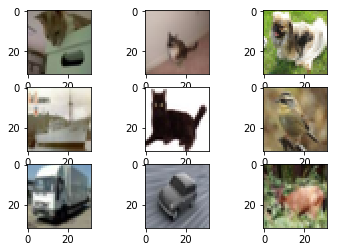

In [266]:
from matplotlib import pyplot
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i])

In [267]:
def model1():

    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(16, (3, 3),
               padding='same',
               kernel_regularizer='l2',
               kernel_initializer='lecun_normal')(inputs)
    x = Activation(activation='selu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3),
               padding='same',
               kernel_regularizer='l2',
               kernel_initializer='lecun_normal')(x)
    x = Activation(activation='selu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3),
               padding='same',
               kernel_regularizer='l2',
               kernel_initializer='lecun_normal')(x)
    x = Activation(activation='selu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3),
               padding='same',
               kernel_regularizer='l2',
               kernel_initializer='lecun_normal')(x)
    x = Activation(activation='selu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), kernel_initializer='lecun_normal')(x)
    x = Activation(activation='selu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation(activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512)(x)
    x = Activation(activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(10)(x)
    y = Activation('softmax')(x)
    model = Model(inputs=inputs, outputs=y)
    return model

In [268]:
def model2():
    # Create the model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

In [269]:
# model = model2()
# model.summary()
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )
# decay = lrate/epochs
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [270]:
# data augmentations
# train_gen = ImageDataGenerator(
#     rotation_range=8,
#     width_shift_range=0.08,
#     shear_range=0.3,
#     height_shift_range=0.08,
#     zoom_range=0.08
# )
# val_gen = ImageDataGenerator()
# train_generator = train_gen.flow(x_train, y_train, batch_size=batch_size)
# val_generator = val_gen.flow(x_val, y_val, batch_size=batch_size)

In [271]:
# callbacks
# tensorboard = TensorBoard(
#     log_dir='./Graph', histogram_freq=0,
#     write_graph=True, write_images=True
# )
# early_stop = EarlyStopping(
#     monitor='val_loss', min_delta=0.0001,
#     patience=2, verbose=1, mode='auto'
# )
# best_model = ModelCheckpoint(
#     '../../models/cifar10.h5', save_best_only=True, verbose=0
# )
# plateau = ReduceLROnPlateau(
#     factor=np.sqrt(0.1), cooldown=0,
#     patience=5, min_lr=0.5e-6
# )

In [272]:
# training
# model.fit_generator(
#     train_generator,
#     steps_per_epoch=x_train.shape[0] // 64,
#     epochs=epochs,
#     validation_data=val_generator,
#     validation_steps=x_val.shape[0] // 64,
#     callbacks=[tensorboard, early_stop, best_model, plateau]
# )
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

In [273]:
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [274]:
model = ResnetBuilder.build_resnet_18((channels, img_height, img_width), 10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 16, 16, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 16, 16, 64)   256         conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 16, 16, 64)   0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
max_poolin

In [275]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [276]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [277]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

In [ ]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_val, y_val),
                    epochs=epochs, verbose=1, max_q_size=100,
                    callbacks=[lr_reducer, early_stopper])

/Users/changkun/dev/haggles/.env/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=98, validation_data=(array([[[..., epochs=50, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`
  """


Epoch 1/50
98/98 [==============================] - 210s 2s/step - loss: 2.1424 - acc: 0.4070 - val_loss: 2.3300 - val_acc: 0.3448
Epoch 2/50
98/98 [==============================] - 210s 2s/step - loss: 1.7958 - acc: 0.5059 - val_loss: 2.6167 - val_acc: 0.2984
Epoch 3/50
98/98 [==============================] - 223s 2s/step - loss: 1.6407 - acc: 0.5556 - val_loss: 2.3128 - val_acc: 0.4123
Epoch 4/50
18/98 [====>.........................] - ETA: 3:03 - loss: 1.5697 - acc: 0.5855

In [188]:
y_ = model.predict(x_test)
y_ = np.argmax(y_, axis=1)

x_id = x_id.reshape(x_id.shape[0], 1)
y_ = y_.reshape(y_.shape[0], 1)
results = np.concatenate((y_, x_id), axis=1)
np.savetxt(path_submission, results, '%d', delimiter=',')